In [181]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
import scipy
import math
import os
import random
import open3d as o3d
# from open3d. import uniform_down_sample
import torch
import scipy.spatial.distance
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

[0.40176077 0.1337709  0.00571454]
0.0027145419237331325 0.006714541923733133


<IPython.core.display.Javascript object>


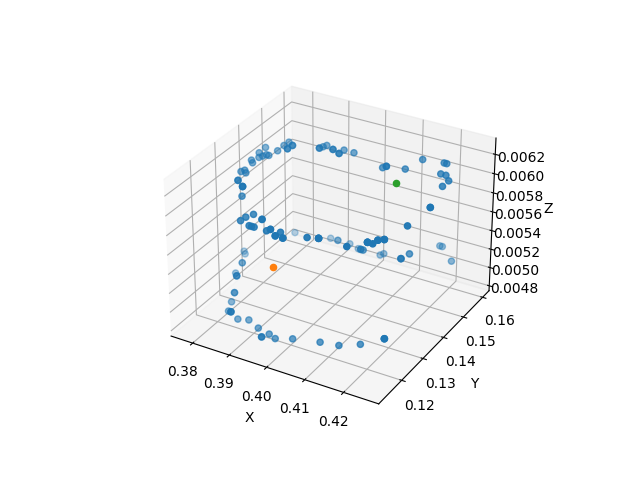

In [145]:
pcd = o3d.io.read_point_cloud('./train/nugg_1.pcd')
xyz = np.asarray(pcd.points)

center = np.mean(xyz, axis=0)
print(center)
print(center[2]-0.003, center[2]+0.001)
xyz = xyz[np.where((xyz[:,2]>center[2]-0.001) & (xyz[:,2]<center[2]+0.001))]
idx = np.random.choice(np.arange(xyz.shape[0]), size=128)
xyz = xyz[idx]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2])

test = [0.4, 0.113, 0.405, 0.16, 0.523599, 0.5, 0.75]

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

x1 = test[:2]
x2 = test[2:4]
ax.scatter(x1[0], x1[1], center[2])
ax.scatter(x2[0], x2[1], center[2])

plt.show()
# # o3d.visualization.draw_geometries([pcd], mesh_show_wireframe=True)

In [146]:
# np.save('data.npy', pt_cloud_data) 

In [147]:
target_output = {
#     x1, y1, x2, y2, pitch, f1, f2
    "nugg_1": np.array([0.4, 0.113, 0.405, 0.16, 0.523599, 0.5, 0.75],)
    "nugg_2": np.array([0.432, 0.08, 0.432, 0.1384, 0.523599, 0.5, 0.75],)
    "nugg_3": np.array([0.42, 0.11, 0.415, 0.163, 0.523599, 0.5, 0.75],)
    "nugg_4": np.array([0.39, 0.11, 0.45, 0.118, 0.523599, 0.5, 0.75],)
    "nugg_5": np.array([0.405, 0.09, 0.46, 0.118, 0.523599, 0.5, 0.75])
}

SyntaxError: invalid syntax (3273502987.py, line 4)

In [148]:
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
        fig = go.Figure(data=data,
            layout=go.Layout(
                updatemenus=[dict(type='buttons',
                    showactive=False,
                    y=1,
                    x=0.8,
                    xanchor='left',
                    yanchor='bottom',
                    pad=dict(t=45, r=10),
                    buttons=[dict(label='Play',
                    method='animate',
                    args=[None, dict(frame=dict(duration=50, redraw=True),
                        transition=dict(duration=0),
                        fromcurrent=True,
                        mode='immediate'
                        )]
                    )
                ])]
            ),
        frames=frames
        )
    return fig

In [7]:
x,y,z = xyz[:,0], xyz[:,1], xyz[:,2]
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50)]).show()

In [8]:
visualize_rotate([go.Scatter3d(x=x, y=y, z=z,mode='markers')]).show()

In [190]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train"):
        self.files = []
        target_output = {
        #     x1, y1, x2, y2, pitch, f1, f2
            "nugg_1": np.array([0.4133, 0.115, 0.4024, 0.1550, 0.524, 0.5, 0.75]),
            "nugg_2": np.array([0.4054, 0.094, 0.4535, 0.1271, 0.524, 0.5, 0.75]),
            "nugg_3": np.array([0.4156, 0.1164, 0.4132, 0.1621, 0.524, 0.5, 0.75]),
            "nugg_4": np.array([0.4017, 0.0874, 0.4305, 0.1325, 0.524, 0.5, 0.75]),
            "nugg_5": np.array([0.4115, 0.0840, 0.4457, 0.1250, 0.524, 0.5, 0.75])
        }
        for i in range(5):
            pcd = o3d.io.read_point_cloud(f'{root_dir}/{folder}/nugg_{i+1}.pcd')
            xyz = np.asarray(pcd.points)
            xyz = xyz[np.where((xyz[:,2]>center[2]-0.001) & (xyz[:,2]<center[2]+0.001))]
            idx = np.random.choice(np.arange(xyz.shape[0]), size=128)
            xyz = xyz[idx]
            sample = {}
            sample['pt_cld'] = xyz
            sample['target'] = target_output[f'nugg_{i+1}']
            self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        pointcloud = self.files[idx]['pt_cld']
        target = self.files[idx]['target']
        return {'pointcloud': torch.from_numpy(pointcloud), 
                'target': torch.from_numpy(target)}

In [191]:
train_ds = PointCloudData('./')
# valid_ds = PointCloudData('./data', valid=True, folder='test', transform=train_transforms)

In [192]:
train_loader = DataLoader(dataset=train_ds, batch_size=1, shuffle=True)
# valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

In [193]:
class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k = k
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 512, 1)
        self.fc1 = nn.Linear(512,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, k*k)
        
#         self.bn1 = nn.BatchNorm1d(64)
#         self.bn2 = nn.BatchNorm1d(128)
#         self.bn3 = nn.BatchNorm1d(512)
#         self.bn4 = nn.BatchNorm1d(256)
#         self.bn5 = nn.BatchNorm1d(128)
    def forward(self, x):
        bs = x.size(0)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = nn.MaxPool1d(x.size(-1))(x)
        x = nn.Flatten(1)(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if x.is_cuda:
            init = init.cuda()
        matrix = self.fc3(x).view(-1, self.k, self.k) + init
        return matrix
    
class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 512, 1)
        
#         self.bn1 = nn.BatchNorm1d(64)
#         self.bn2 = nn.BatchNorm1d(128)
#         self.bn3 = nn.BatchNorm1d(512)
    def forward(self, x):
        matrix3x3 = self.input_transform(x)
        x = torch.bmm(torch.transpose(x, 1, 2), matrix3x3).transpose(1,2)
        x = F.relu(self.conv1(x))
        matrix64x64 = self.feature_transform(x)
        x = torch.bmm(torch.transpose(x, 1, 2), matrix64x64).transpose(1,2)
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = nn.MaxPool1d(x.size(-1))(x)
        x = nn.Flatten(1)(x)
        return x, matrix3x3, matrix64x64
    
class PointNet(nn.Module):
    def __init__(self, tgt_layer = 7):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, tgt_layer)
        
#         self.bn1 = nn.BatchNorm1d(256)
#         self.bn2 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(p=0.3)
#         self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x, mat3, mat64 = self.transform(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.dropout(self.fc2(x)))
        x = self.fc3(x)
        return x, mat3, mat64

In [194]:
def pointnetloss(output, target, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.MSELoss()
#     bs=target.size(0)
#     id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
#     id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
#     if target.is_cuda:
#         id3x3=id3x3.cuda()
#         id64x64=id64x64.cuda()
#     diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
#     diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    final_loss = criterion(output, target) #+ alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)
    return final_loss

In [195]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [196]:
def train(model, optim, train_loader, val_loader=None, epochs=20, save=True, print_every=10):
    prev_val_acc = 0
    min_loss = 999
    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        for i,data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['target'].to(device).float()
#             print(inputs.shape)
            optim.zero_grad()
            y, m3, m64 = model(inputs.transpose(1,2))
            loss = pointnetloss(y, labels, m3, m64)
            loss.backward()
            optim.step()
            avg_loss += loss.item()
            if i%print_every==0:
                pass
        
        if min_loss > avg_loss/5:
            min_loss = avg_loss/5
            
            print(f"Epoch {epoch}, avg_loss: {avg_loss/5}, min_loss: {min_loss}")
            if save:
                torch.save(model.state_dict(), f"./checkpoints/ckpt_min_loss.pt")
        model.eval()
        correct = total = 0
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['target'].to(device)
                    y, _, _ = model(inputs.transpose(1,2))
                    _, predicted = torch.max(y.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100*correct/total
            if val_acc > prev_val_acc:
                prev_val_acc = val_acc
    return model
                

def load_model(path, device):
    pointnet = PointNet()
    pointnet.to(device)
    optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)
    torch.load(path, map_location=device)

In [197]:
pointnet = PointNet()
pointnet.to(device)
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)
train(pointnet, optimizer, train_loader, epochs=1000,  save=True, print_every=5)

Epoch 0, avg_loss: 0.167088320851326, min_loss: 0.167088320851326
Epoch 1, avg_loss: 0.06633727699518203, min_loss: 0.06633727699518203
Epoch 2, avg_loss: 0.022996257431805132, min_loss: 0.022996257431805132
Epoch 4, avg_loss: 0.022837360575795173, min_loss: 0.022837360575795173
Epoch 5, avg_loss: 0.016622455976903438, min_loss: 0.016622455976903438
Epoch 9, avg_loss: 0.01329210503026843, min_loss: 0.01329210503026843
Epoch 11, avg_loss: 0.011769658792763949, min_loss: 0.011769658792763949
Epoch 14, avg_loss: 0.0073987339623272416, min_loss: 0.0073987339623272416
Epoch 17, avg_loss: 0.006342638144269585, min_loss: 0.006342638144269585
Epoch 18, avg_loss: 0.00577927915728651, min_loss: 0.00577927915728651
Epoch 19, avg_loss: 0.005114735988900066, min_loss: 0.005114735988900066
Epoch 25, avg_loss: 0.00372562687844038, min_loss: 0.00372562687844038
Epoch 37, avg_loss: 0.0033924121642485263, min_loss: 0.0033924121642485263
Epoch 53, avg_loss: 0.0018549016676843166, min_loss: 0.001854901667

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=512, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=128, bias=True)
      (fc3): Linear(in_features=128, out_features=9, bias=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=512, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=128, bias=True)
      (fc3): Linear(in_features=128, out_features=4096, bias=True)
    )
    (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (con

In [200]:
def test(model, pcd_path):
    pcd = o3d.io.read_point_cloud(pcd_path)
    xyz = np.asarray(pcd.points)
    center = np.mean(xyz, axis=0)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2])
    xyz = xyz[np.where((xyz[:,2]>center[2]-0.001) & (xyz[:,2]<center[2]+0.001))]
    idx = np.random.choice(np.arange(xyz.shape[0]), size=128)
    xyz = xyz[idx]
    

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')


    xyz = torch.from_numpy(xyz).unsqueeze(0).to(device).float()
    
    with torch.no_grad():
        result = model(xyz.transpose(1,2))[0].detach().cpu().numpy()[0]
    print(result)
    
    x1 = result[:2]
    x2 = result[2:4]
    ax.scatter(x1[0], x1[1], center[2])
    ax.scatter(x2[0], x2[1], center[2])
    plt.show()

<IPython.core.display.Javascript object>


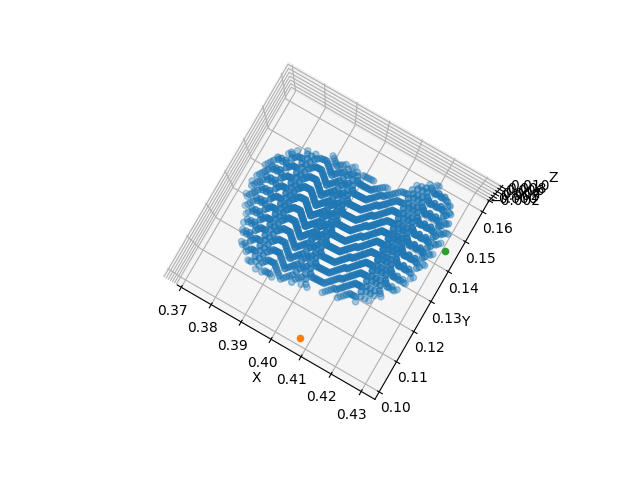

[0.4079442  0.10172078 0.43036288 0.14215162 0.52175903 0.50023067
 0.7473546 ]


In [205]:

pointnet = PointNet()
pointnet.load_state_dict(torch.load("./checkpoints/ckpt_min_loss.pt"))
pointnet.eval();

test(trained_model, './train/nugg_1.pcd')